# <font color='CornflowerBlue'>Benchmarking CellFindPy</font>

### <font color='CornflowerBlue'>Written by Richard Perez, UCSF</font>

## <font color='CornflowerBlue'>Import libraries</font>

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0 # Only print errors
sc.settings.set_figure_params(color_map='viridis')
os.chdir('/Users/richardperez/Documents/Tward_Lab.nosync/Human_Inner_Ear_Project/Benchmark_Files')

## <font color='CornflowerBlue'>Run CellFindPy on real PBMC single-cell RNA seq data.</font>

In [1]:
'''
populations = ['5', '10', '20', '30', '40', '50', '60']
for ii in range(23):
    for pop in populations:
        os.chdir('/path/to/Benchmark_Files')
        file = 'Replicate_{}_{}k.h5ad'.format(ii, pop)
        output = 'Replicate_{}_{}k'.format(ii, pop)
        %run '/path/to/CellFindPy/CellFindPy.py' '-i {file}' '-o {output}' '-s {False}'
'''

"\npopulations = ['5', '10', '20', '30', '40', '50', '60']\nfor ii in range(23):\n    for pop in populations:\n        os.chdir('/path/to/Benchmark_Files')\n        file = 'Replicate_{}_{}k.h5ad'.format(ii, pop)\n        output = 'Replicate_{}_{}k'.format(ii, pop)\n        %run '/path/to/CellFindPy/CellFindPy/CellFindPy.py' '-i {file}' '-o {output}' '-s {False}'\n"

## <font color='CornflowerBlue'>SymSim Synthetic single-cell RNA sequencing data.</font>

[Zhang, Xiuwei, Chenling Xu, and Nir Yosef. "Simulating multiple faceted variability in single cell RNA sequencing." Nature communications 10.1 (2019): 1-16.](https://www.nature.com/articles/s41467-019-10500-w)
    
    

In [130]:
'''
def compile_simulation(ii, label_dict):
    data = np.transpose(pd.read_csv('Simdata_{}.csv'.format(ii), index_col=0).values)
    labels = pd.read_csv('Simdata_{}_labels.csv'.format(ii), index_col=0)['x'].tolist()
    labels = [label_dict[l] for l in labels]
    return data, labels

# hierarchically related populations
label_dict = {1:'1.1',2:'1.2.1',3:'1.2.2.1', 4:'1.2.2.2'}
data0, labels0 = compile_simulation(0, label_dict)

label_dict = {1:'2.1',2:'2.2.1',3:'2.2.2.1', 4:'2.2.2.2'}
data1, labels1 = compile_simulation(1, label_dict)

label_dict = {1:'3.1',2:'3.2.1',3:'3.2.2.1', 4:'3.2.2.2'}
data2, labels2 = compile_simulation(2, label_dict)

label_dict = {1:'4.1',2:'4.2.1',3:'4.2.2.1', 4:'4.2.2.2'}
data3, labels3 = compile_simulation(3, label_dict)

label_dict = {1:'5.1',2:'5.2.1',3:'5.2.2.1', 4:'5.2.2.2'}
data4, labels4 = compile_simulation(4, label_dict)

label_dict = {1:'6.1',2:'6.2.1',3:'6.2.2.1', 4:'6.2.2.2'}
data5, labels5 = compile_simulation(5, label_dict)

data = np.concatenate([data0, data1, data2, data3, data4, data5])
labels = labels0+labels1+labels2+labels3+labels4+labels5

os.chdir('/path/to/Benchmark_Files')

# Package data into an Anndata file.
obs = pd.DataFrame(index=list(range(data.shape[0])))
var = pd.DataFrame(index=list(range(data.shape[1])))
data = ad.AnnData(data, obs=obs, var=var, dtype='int64')
data.raw = data.copy();
data.obs['Ground Truth'] = labels
data.obs['Ground Truth'] = data.obs['Ground Truth'].astype('category')
data.write_h5ad('Simdata_120k.h5ad')

# Same a synthetic data file for each size (1k-32k).
adata = sc.read('Simdata_120k.h5ad')
clusters = data.obs['Ground Truth'].unique().tolist()
sizes = np.asarray([0.30, 0.25, 0.20, 0.18, 0.16, 0.14, 0.12, 0.10, 0.09, 0.08, 0.07, 0.06,
                    0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.0025])

keep = []
for ii in range(len(clusters)):
    keep.extend(list(np.random.choice(data[data.obs['Ground Truth']==clusters[ii]].obs_names.tolist(),
    int((5000/.30)*sizes[ii]), replace=False)))
    
data = data[data.obs_names.isin(keep)]
print(data)
sc.pp.subsample(data, n_obs=32000)
data.write_h5ad('Simdata_32k.h5ad')

adata = sc.read('Simdata_32k.h5ad')
print(adata)
simrange = np.flipud(np.asarray(range(31))+1)
for s in simrange:
    sc.pp.subsample(adata, n_obs=s*1000)
    adata.write_h5ad('Simdata_{}k.h5ad'.format(s))
    
for ii in range(len(np.asarray(range(32)))):
    data = sc.read('Simdata_{}k.h5ad'.format(ii+1))
    sc.pp.normalize_total(data, exclude_highly_expressed=True)
    sc.pp.filter_genes(data, min_counts=20, inplace=True) # Speed up processing
    sc.pp.filter_genes(data, min_cells=10, inplace=True) # Speed up processing
    sc.pp.log1p(data)
    sc.pp.pca(data, random_state=0)
    sc.pp.neighbors(data, random_state=0)
    sc.tl.umap(data, random_state=0)
    sc.tl.leiden(data,resolution=1, random_state=0)
    sc.tl.louvain(data,resolution=1, random_state=0)
    data.write_h5ad('Simdata_{}k.h5ad'.format(ii+1))
    os.mkdir('Simdata_{}k'.format(ii+1))
    data.write_csvs('Simdata_{}k'.format(ii+1), skip_data=False)

'''
'''

## <font color='CornflowerBlue'>Run Simulated data. </font>

In [1]:
'''
for ii in np.asarray(range(32))+1:
    os.chdir('/path/to/Benchmark_Files')
    file = 'Simdata_{}k.h5ad'.format(ii)
    output = 'Simdata_{}k'.format(ii)
    %run '/path/to/CellFindPy/CellFindPy.py' '-d {file}' '-o {output}'
'''

"\nfor ii in np.asarray(range(32))+1:\n    os.chdir('/Users/richardperez/Documents/Tward_Lab.nosync/Human_Inner_Ear_Project/Benchmark_Files')\n    file = 'Simdata_{}k.h5ad'.format(ii)\n    output = 'Simdata_{}k'.format(ii)\n    %run '/Users/richardperez/Documents/Tward_Lab.nosync/Human_Inner_Ear_Project/CellFindPy/CellFindPy/CellFindPy.py' '-d {file}' '-o {output}'\n"

## <font color='CornflowerBlue'>Simulation Results. </font>

In [16]:
k = np.asarray(range(32))+1 # 1-32
results = pd.DataFrame(index=k, columns=['leiden', 'louvain', 'CellFindPy'])
for ii in k:
    adata = sc.read('Simdata_{}k.h5ad'.format(ii))
    adata.obs['CellFindPy'] = pd.read_csv(os.getcwd()+'/Simdata_{}k/CellFindPy_Groups.csv'.format(ii), index_col=0)['CellFindPy'].tolist()
    adata.obs['CellFindPy'] = adata.obs['CellFindPy'].astype('category')
    #adata.obs['Ground Truth'][adata.obs['Ground Truth'].isin(['6.2.1', '6.2.2.1', '6.2.2.2'])] = '6.1'
    results.loc[ii, 'leiden'] = metrics.adjusted_rand_score(adata.obs['Ground Truth'].tolist(), adata.obs['leiden'].tolist())
    results.loc[ii, 'louvain'] = metrics.adjusted_rand_score(adata.obs['Ground Truth'].tolist(), adata.obs['louvain'].tolist())
    results.loc[ii, 'CellFindPy'] = metrics.adjusted_rand_score(adata.obs['Ground Truth'].tolist(), adata.obs['CellFindPy'].tolist())

results = results.rolling(4, min_periods=1, win_type='boxcar').mean() # Smooth adjusted rand scores

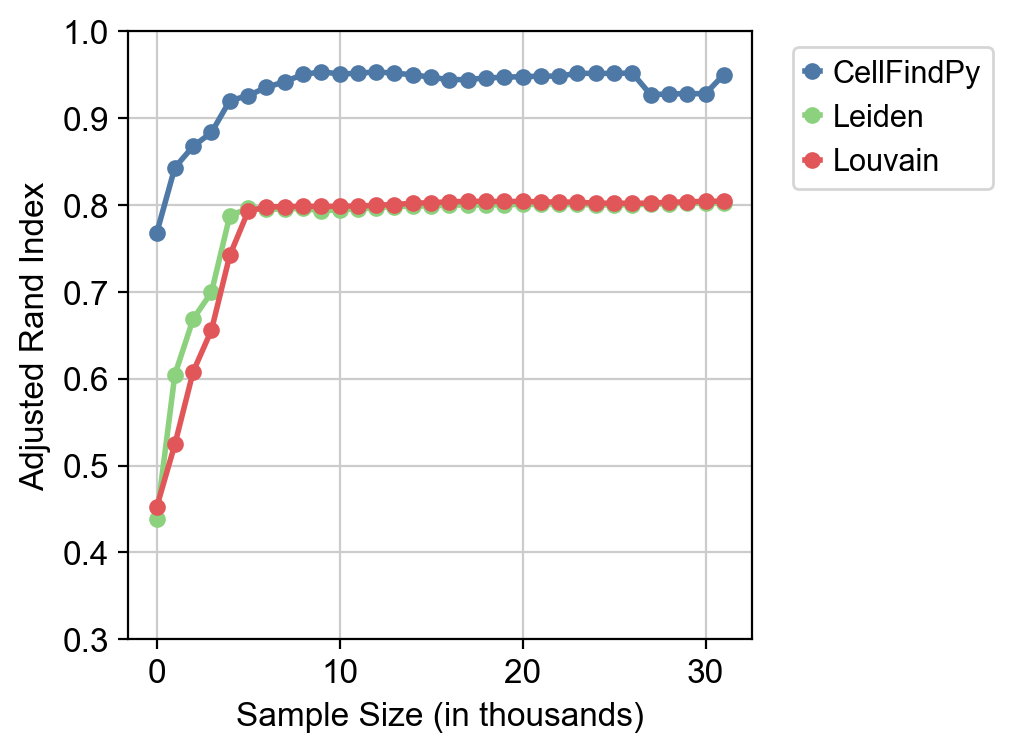

In [38]:
colorrs = ["#4E79A7","#A0CBE8","#F28E2B","#FFBE7D","#8CD17D","#B6992D","#499894","#E15759","#FF9D9A","#79706E",
           "#D37295","#FABFD2","#B07AA1","#D4A6C8","#9D7660","#E58606", "#5D69B1", "#24796C",
           '#DAA51B', '#000000', '#99C945', '#ED645A']
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=12)

plt.plot(results.dropna()['CellFindPy'].values, label='CellFindPy', color=colorrs[0], linewidth=2, marker="o",  markersize=5)
plt.plot(results.dropna()['leiden'].values, label='Leiden', color=colorrs[4], linewidth=2, marker="o",  markersize=5)
plt.plot(results.dropna()['louvain'].values, label='Louvain', color=colorrs[7], linewidth=2, marker="o",  markersize=5)
plt.xlabel('Sample Size (in thousands)')
plt.ylabel('Adjusted Rand Index')
plt.ylim(0.3,1)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig("Adjusted Rand Index.png")



## <font color='CornflowerBlue'>How CellFindPy communities match up to Ground Truth Communities. </font>

In [9]:
ii=32
adata = sc.read('Simdata_{}k.h5ad'.format(ii))
adata.obs['CellFindPy'] = pd.read_csv(os.getcwd()+'/Simdata_{}k/CellFindPy_Groups.csv'.format(ii), index_col=0)['CellFindPy'].tolist()
adata.obs['CellFindPy'] = adata.obs['CellFindPy'].astype('category')

sizes = np.asarray([0.30, 0.25, 0.20, 0.18, 0.16, 0.14, 0.12, 0.10, 0.09, 0.08, 0.07, 0.06,
                    0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.0025])
cluster_ids = ['1.1', '1.2.1', '1.2.2.1', '1.2.2.2', '2.1', '2.2.1', '2.2.2.1','2.2.2.2',
               '3.1', '3.2.1', '3.2.2.1', '3.2.2.2', '4.1', '4.2.1','4.2.2.1', '4.2.2.2',
               '5.1', '5.2.1', '5.2.2.1', '5.2.2.2', '6.1','6.2.1', '6.2.2.1', '6.2.2.2']
cluster_ids_dict = {}

for ii in range(len(cluster_ids)):
    cluster_ids_dict[cluster_ids[ii]] = sizes[ii]
    
Ground_Truth_size = [cluster_ids_dict[adata.obs['Ground Truth'][ii]] for ii in range(len(adata.obs['Ground Truth'].tolist()))]

adata.obs['Ground Truth Size'] = Ground_Truth_size
    

<Figure size 1500x1500 with 0 Axes>

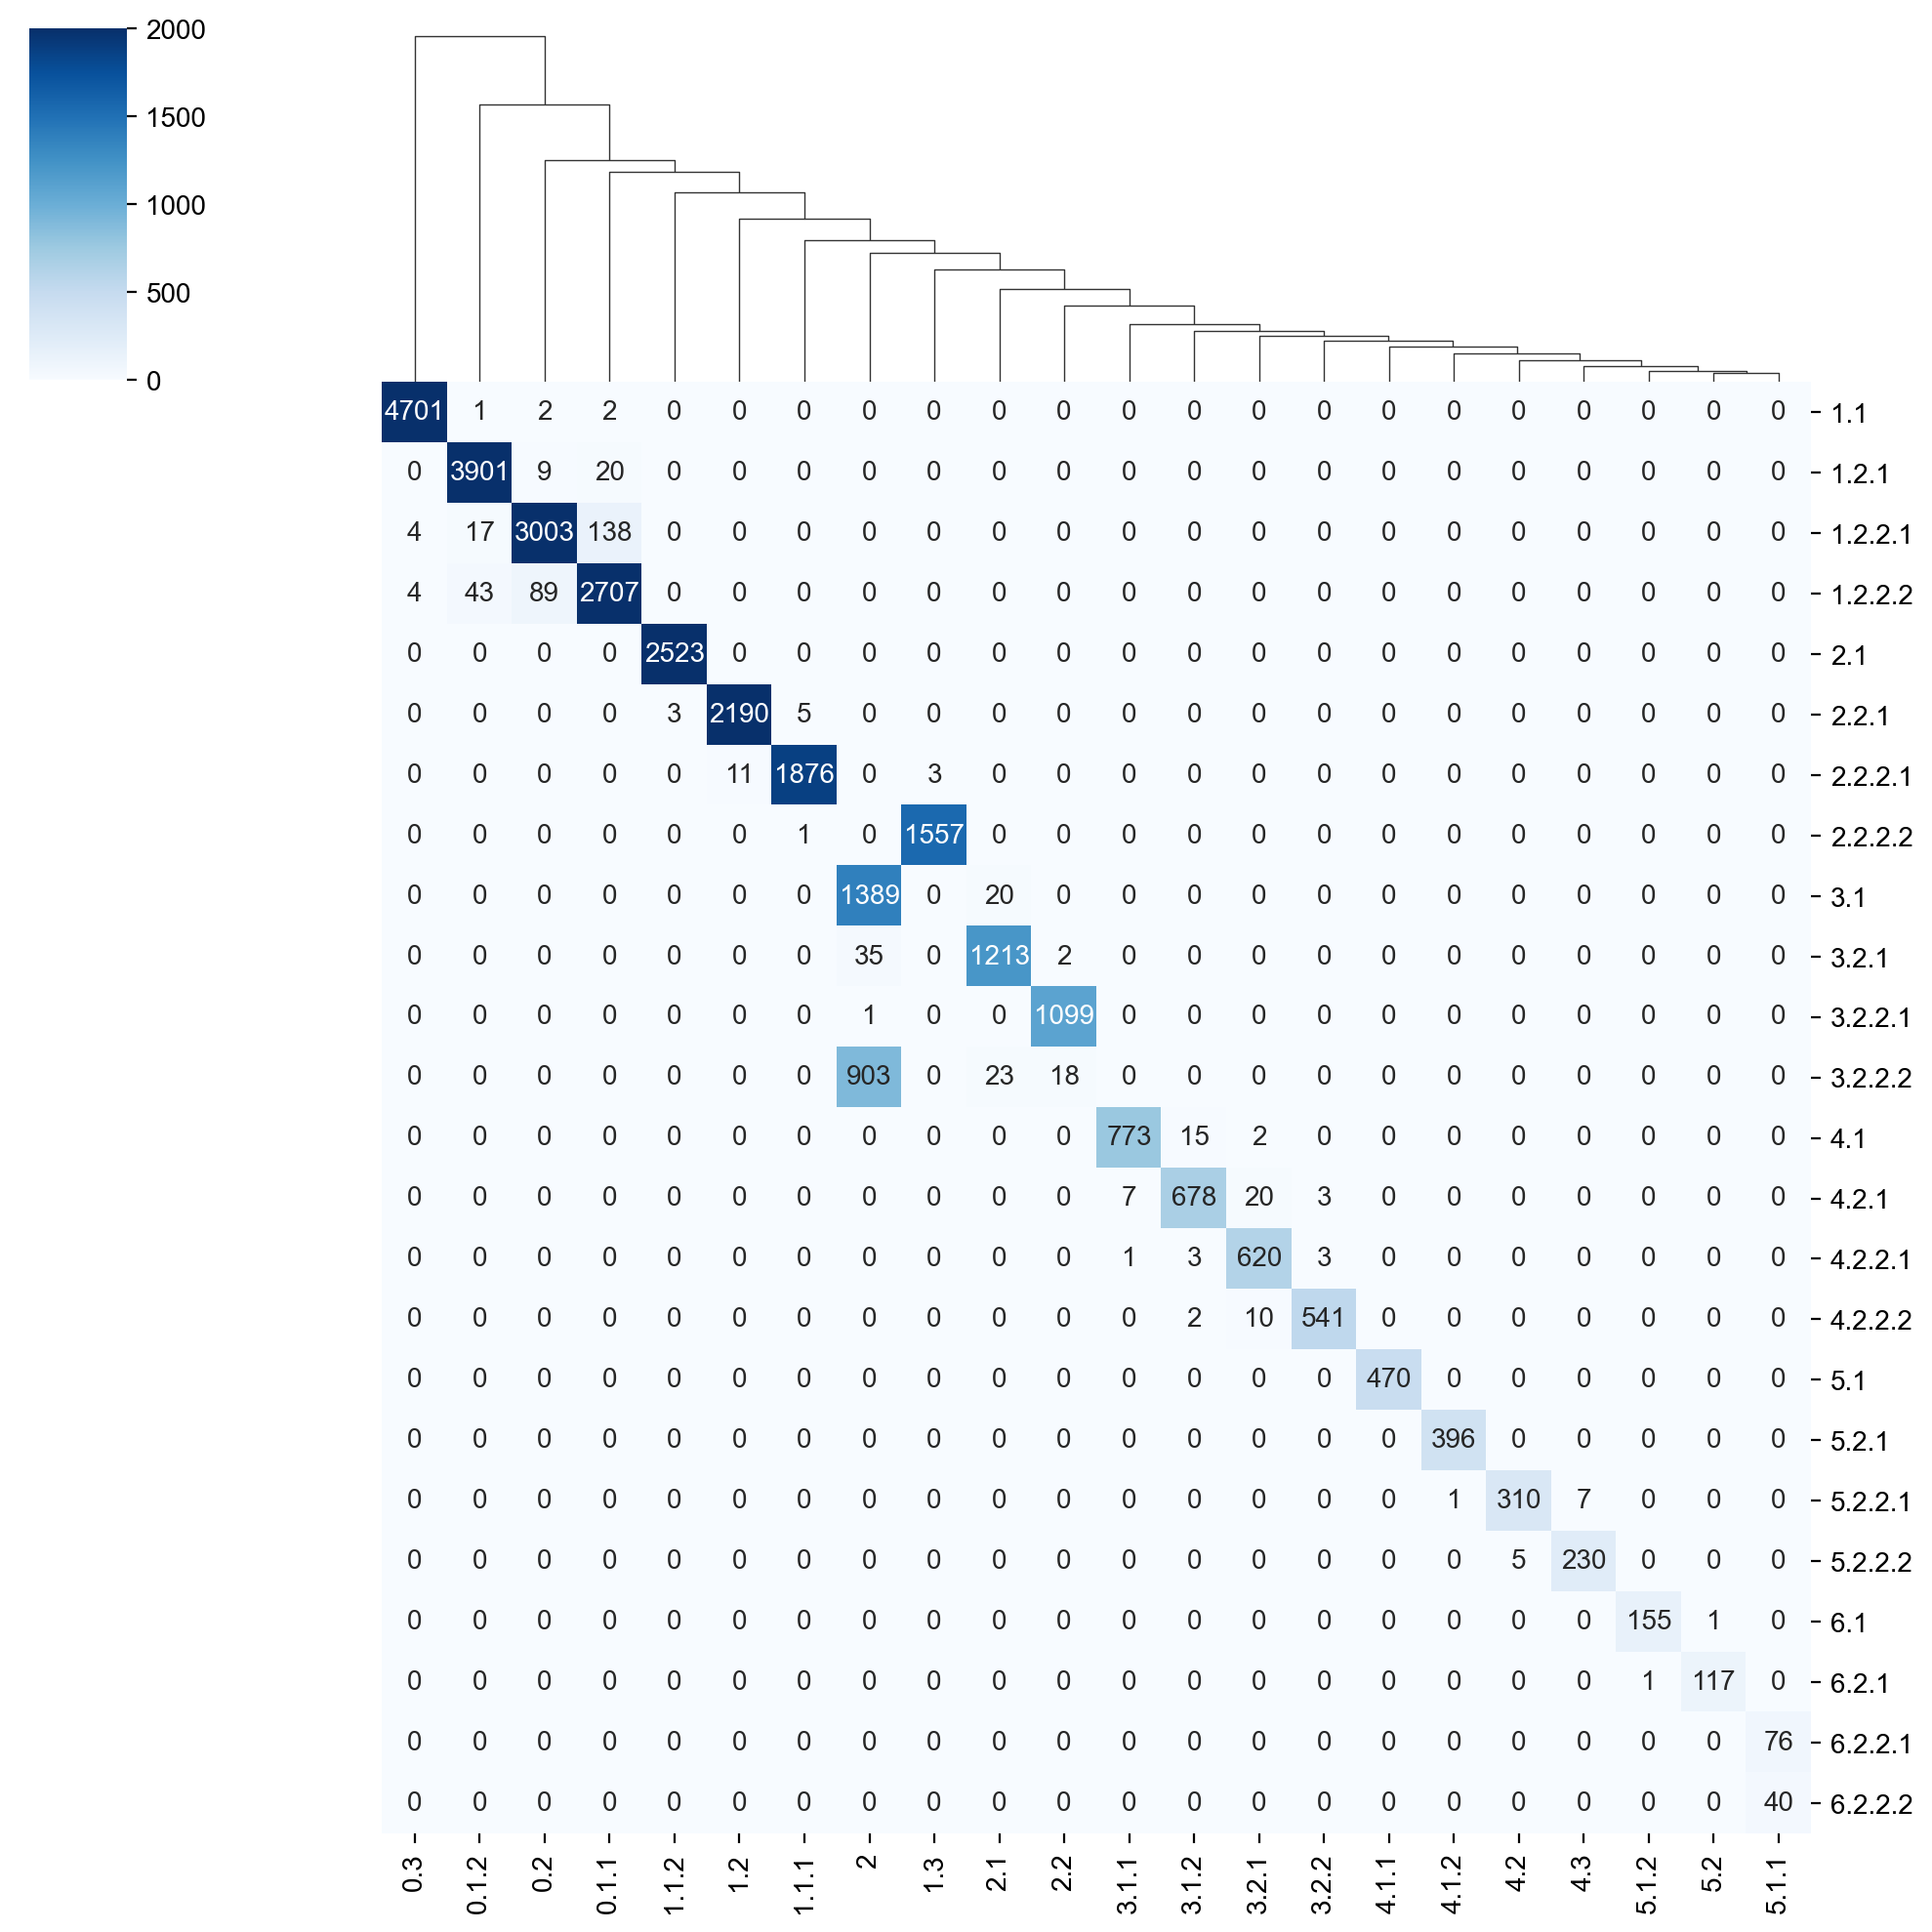

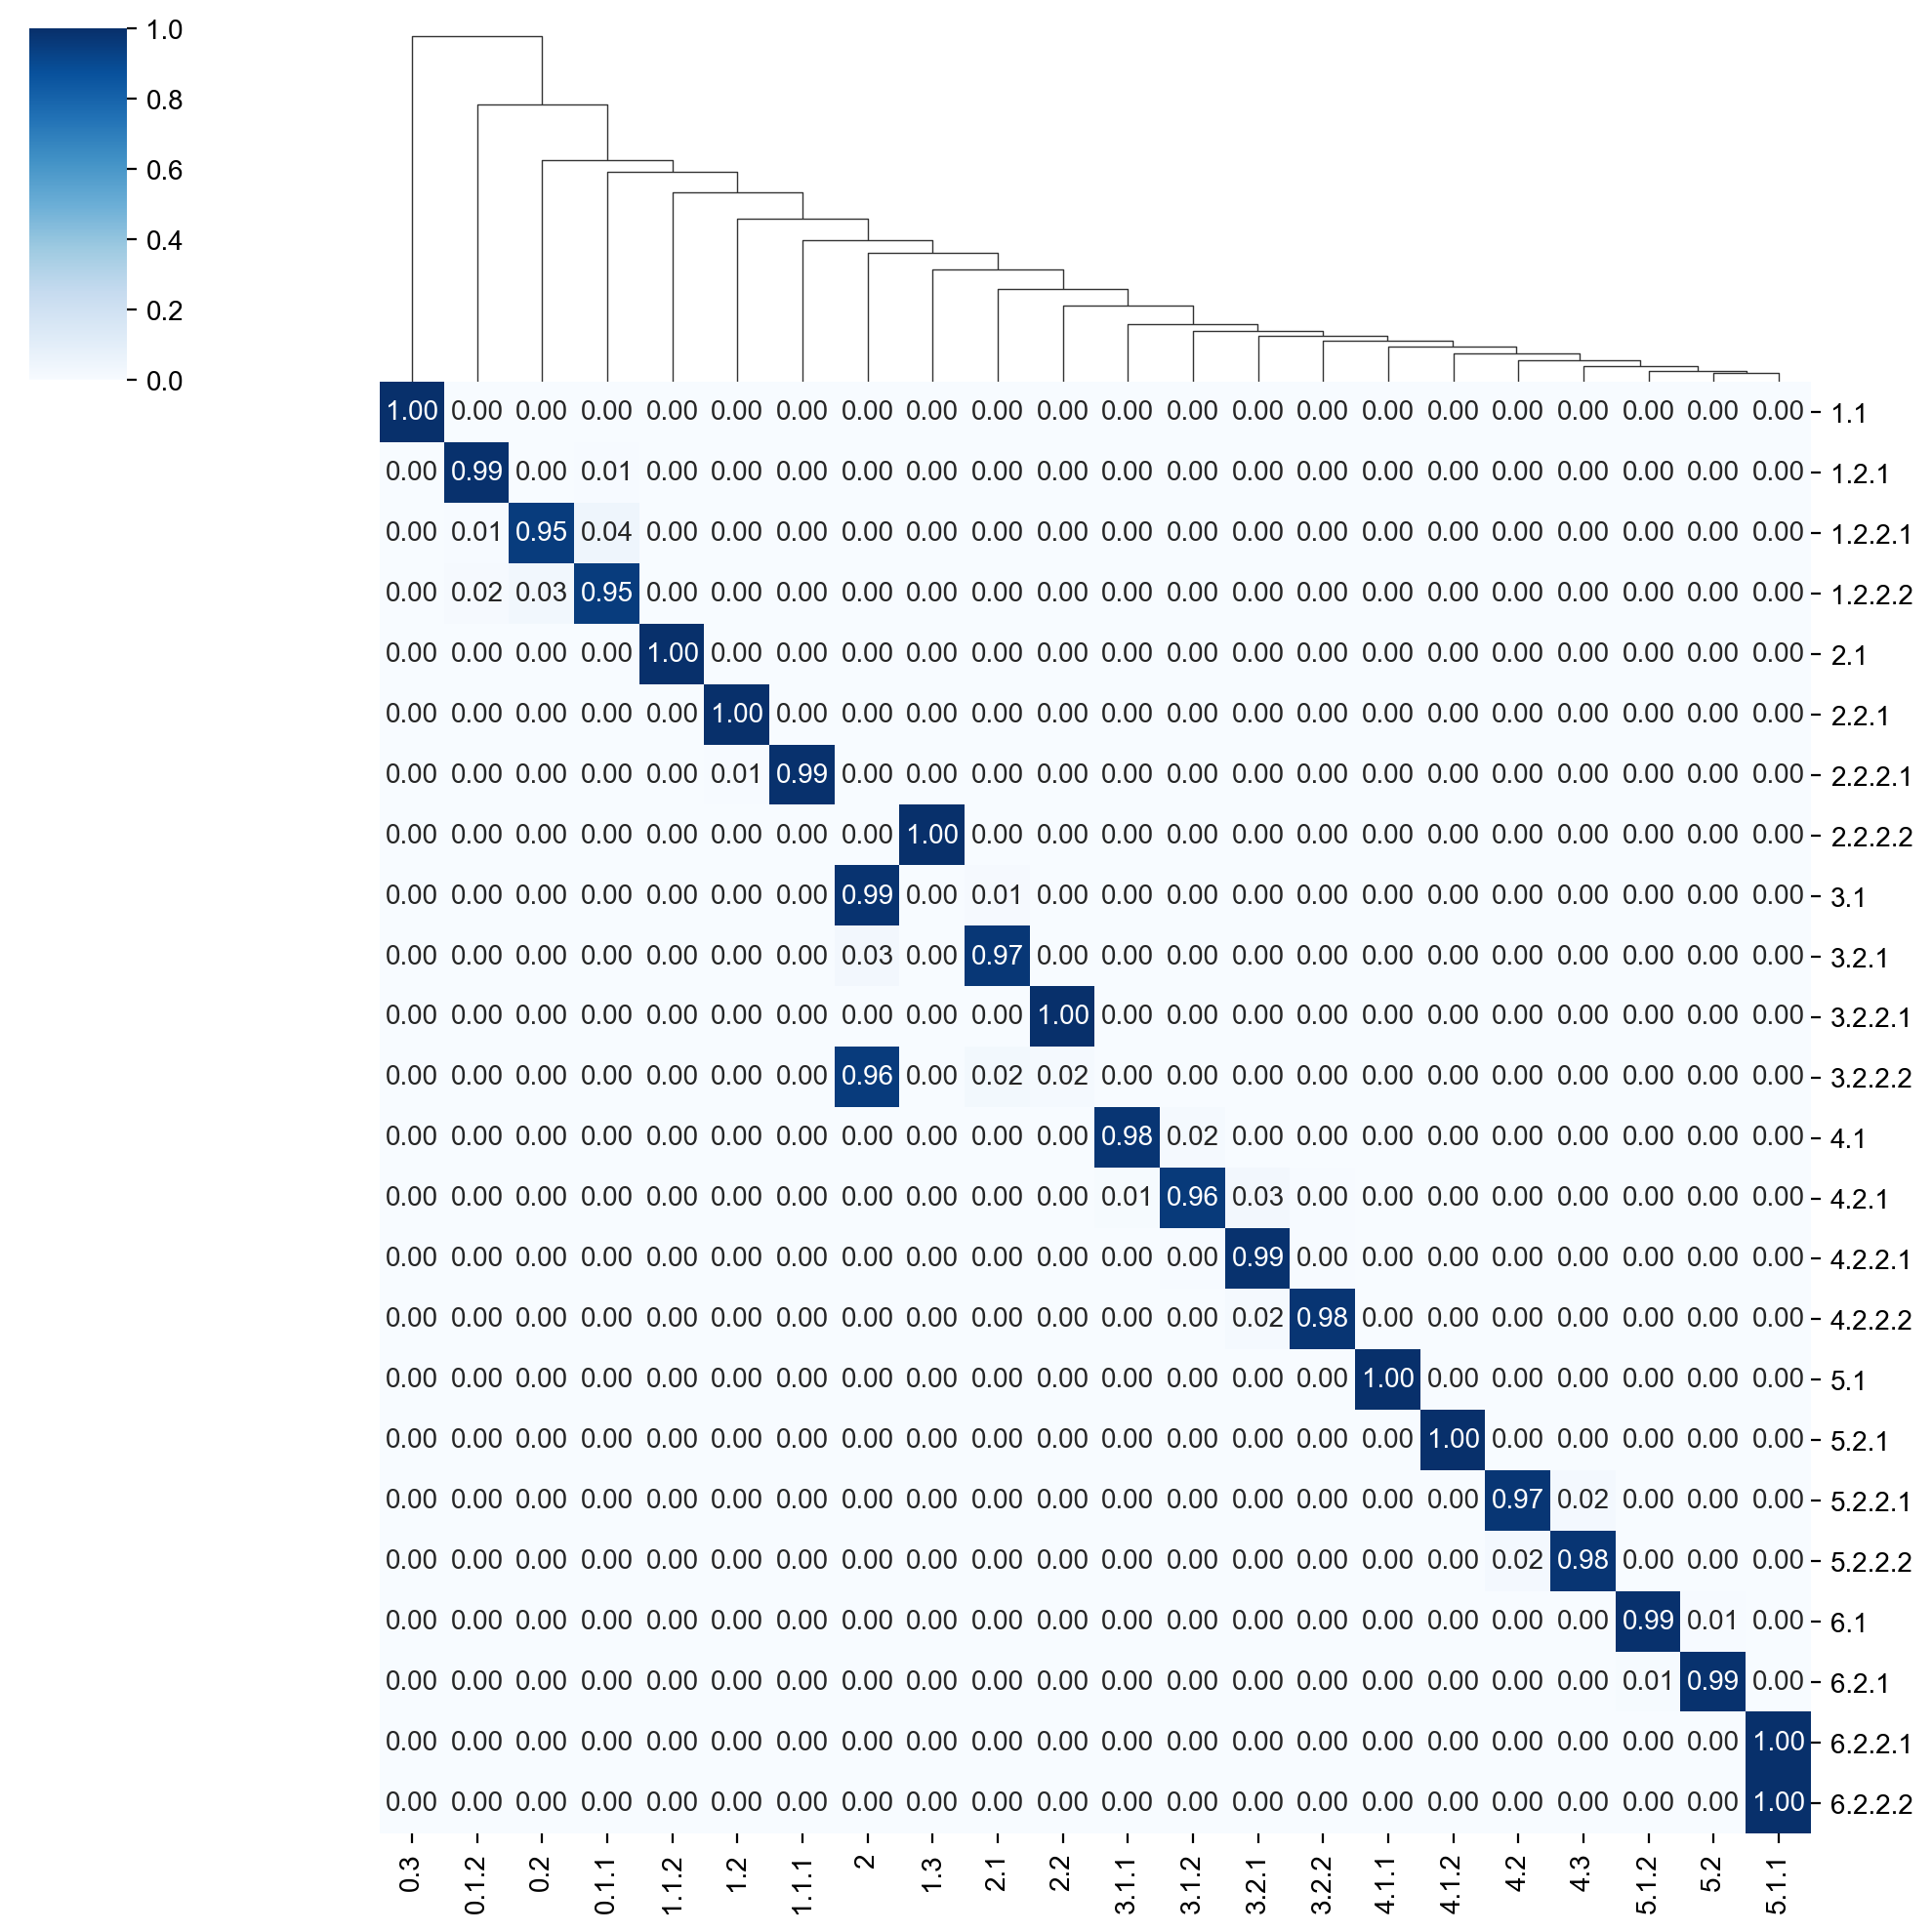

In [10]:
fig = plt.figure(figsize=(15,15))
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=10)
tmp = adata.obs.sort_values('Ground Truth')
x = contingency_matrix(tmp['Ground Truth'].tolist(), tmp['CellFindPy'].tolist())
df_cm = pd.DataFrame(x, index = tmp['Ground Truth'].unique().tolist(),
                  columns = tmp['CellFindPy'].unique().tolist())
res = sns.clustermap(df_cm, annot=True, row_cluster=False, col_cluster=True,
                     vmin=0, vmax=2000, fmt='.0f', cmap="Blues", method='complete')
col_order = res.dendrogram_col.calculated_linkage
df_cm = df_cm/df_cm.sum(axis=1)[:,None]
res = sns.clustermap(df_cm, annot=True, row_cluster=False, col_cluster=True, col_linkage=col_order,
                     vmin=0, vmax=1, fmt='.2f', cmap="Blues")

## <font color='CornflowerBlue'>Number and replicability of communities based on real data. </font>

In [2]:
def evaluate_algos(pop, iterations):
    for ii in range(iterations): # Go through all 23 replicates. For some samples, there may be < 23 replicates.
        try:
            adata = sc.read('Replicate_{}_{}k.h5ad'.format(ii, pop))
            adata.obs['leiden'] = pd.read_csv('Replicate_{}_{}k/leiden_louvain.csv'.format(ii,pop), index_col=0)['leiden'].astype('category') # Resolution = 1
            adata.obs['louvain'] = pd.read_csv('Replicate_{}_{}k/leiden_louvain.csv'.format(ii,pop), index_col=0)['louvain'].astype('category') # Resolution = 1
            adata.obs['CellFindPy'] = pd.read_csv('Replicate_{}_{}k/CellFindPy_Groups.csv'.format(ii,pop), index_col=0)['CellFindPy'].astype('category')

            if ii == 0:
                CFPyFrame = pd.DataFrame(index=adata.var_names.tolist()); CFPy_size = {}
                leidenFrame = pd.DataFrame(index=adata.var_names.tolist()); leiden_size = {}
                louvainFrame = pd.DataFrame(index=adata.var_names.tolist()); louvain_size = {}


            def fillframe(adata, Frame, size_dict, ii, algo):
                clusters = adata.obs[algo].unique()
                for c in clusters:
                    Frame['{}-{}'.format(ii, c)] = pd.DataFrame(index=adata.var_names.tolist(), data=np.ravel(csr_matrix(adata[adata.obs[algo]==c].X).mean(axis=0)))
                    size_dict['{}-{}'.format(ii, c)] = adata[adata.obs[algo]==c].X.shape[0] / adata.shape[0] # Retain size of cluster

                return Frame, size_dict


            CFPyFrame, CFPy_size = fillframe(adata, CFPyFrame, CFPy_size, ii, 'CellFindPy')
            louvainFrame, louvain_size = fillframe(adata, louvainFrame, louvain_size, ii, 'louvain')
            leidenFrame, leiden_size = fillframe(adata, leidenFrame, leiden_size, ii, 'leiden')

        except:
            print('No replicate found for Replicate_{}_{}k.'.format(ii, pop))
            continue

            
    def doframecorr(Frame, C_size):
        Frame = Frame.dropna(axis=0)
        FrameCorr = Frame.corr('pearson')
        n_replicates = len(np.unique(np.asarray([FrameCorr.index.tolist()[ii].split('-')[0] for ii in range(len(FrameCorr.index.tolist()))]))) # Number of unique replicates

        CLUSTERS = FrameCorr.index.tolist() # Get complete list of clusters
        C_associates = {k: [] for k in CLUSTERS} # Create results dictionary
        for cc in range(len(CLUSTERS)):
            tmp_list = FrameCorr[CLUSTERS[cc]].drop(CLUSTERS[cc]) # List of correlations to this cluster minus itself
            rep = np.asarray([tmp_list.index.tolist()[ii].split('-')[0] for ii in range(len(tmp_list.index.tolist()))]) # Exclude other clusters from same replicate
            ref_list = tmp_list[np.asarray(tmp_list.index.tolist())[rep==CLUSTERS[cc].split('-')[0]]].index.tolist() # Keep list of clusters from same replicate.
            tmp_list = tmp_list.drop(np.asarray(tmp_list.index.tolist())[rep==CLUSTERS[cc].split('-')[0]]) # Slice array
            while len(tmp_list)>0:
                # Find highest correlated cluster from other replicates that is not more correlated to another cluster within the same replicate
                if (np.sum(FrameCorr.loc[ref_list][tmp_list.index[np.argmax(tmp_list)]] > tmp_list[np.argmax(tmp_list)])<1) & (tmp_list[np.argmax(tmp_list)]>=0.5):
                    C_associates[CLUSTERS[cc]].append(tmp_list.index[np.argmax(tmp_list)])
                    rep = np.asarray([tmp_list.index.tolist()[ii].split('-')[0] for ii in range(len(tmp_list.index.tolist()))]) # get cluster membership
                    tmp_list = tmp_list.drop(np.asarray(tmp_list.index.tolist())[rep==tmp_list.index[np.argmax(tmp_list)].split('-')[0]]) # Slice array
                else:
                    tmp_list = tmp_list.drop(tmp_list.index[np.argmax(tmp_list)]) # Remove candidate from consideration

        results = pd.DataFrame(index=list(C_associates.keys()), columns=['Proportion', 'Size'])
        for cc in list(C_associates.keys()):
            results.loc[cc, 'Proportion'] = len(C_associates[cc])/(n_replicates-1)
            results.loc[cc, 'Size'] = C_size[cc]
        results = results.sort_values('Size', ascending=False)
        return results

    CFPy_results = doframecorr(CFPyFrame, CFPy_size)
    louvain_results = doframecorr(louvainFrame, louvain_size)
    leiden_results = doframecorr(leidenFrame, leiden_size)
    return CFPy_results, leiden_results, louvain_results


def makeheatmap(replication_results):
    sizes = [0.15, 0.10, 0.05, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001,  0.00001]
    Median_recovery_rate = pd.DataFrame(index=sizes, columns=list(replication_results.keys()))
    Median_recovery_rate_n = pd.DataFrame(index=sizes, columns=list(replication_results.keys()))
    for rr in list(replication_results.keys()):
        for s in range(len(sizes)):
            try:
                if s == 0:
                    Median_recovery_rate.loc[sizes[s], rr] = np.median(replication_results[rr][replication_results[rr]['Size']>=sizes[s]]['Proportion'].values)
                    Median_recovery_rate_n.loc[sizes[s], rr] = len(replication_results[rr][replication_results[rr]['Size']>=sizes[s]]['Proportion'].values)
                else:
                    Median_recovery_rate.loc[sizes[s], rr] = np.median(replication_results[rr][(replication_results[rr]['Size']>=sizes[s]) & (replication_results[rr]['Size']<sizes[s-1])]['Proportion'].values)
                    Median_recovery_rate_n.loc[sizes[s], rr] = len(replication_results[rr][(replication_results[rr]['Size']>=sizes[s]) & (replication_results[rr]['Size']<sizes[s-1])]['Proportion'].values)
            except:
                Median_recovery_rate.loc[sizes[s], rr] = 0
                Median_recovery_rate_n.loc[sizes[s], rr] = 0
                continue
        
    Median_recovery_rate = Median_recovery_rate.astype('float')
    Median_recovery_rate_n = Median_recovery_rate_n.astype('float')
    Median_recovery_rate.index = np.asarray(Median_recovery_rate.index.tolist())*100
    Median_recovery_rate_n.index = np.asarray(Median_recovery_rate_n.index.tolist())*100
    return Median_recovery_rate, Median_recovery_rate_n


def plotheatmap(recovery_rateframe, title, vmin=0, vmax=1, cmap='Blues'):
    sc.settings.set_figure_params(dpi=150, dpi_save=700, format='png', frameon=False, transparent=True, fontsize=8)
    plt.figure()
    sns.heatmap(recovery_rateframe, annot=True, cmap=cmap, linewidths=.2, vmin=vmin, vmax=vmax)
    plt.xlabel('Sample Size (thousands of cells)')
    plt.ylabel('Cluster Size as a Percentage of Total Population')
    plt.title(title)

In [3]:
os.chdir('/Users/richardperez/Documents/Tward_Lab.nosync/Human_Inner_Ear_Project/Benchmark_Files')

CFPy_results = {}; leiden_results = {}; louvain_results = {};
replication_info = ['5','10','20','30','40','50','60']
for rr in replication_info:
    print('Processing {}k...'.format(rr))
    CFPy_results[rr], leiden_results[rr], louvain_results[rr] = evaluate_algos(rr, iterations=23)

CFPy_recovery_rate, CFPy_recovery_rate_n = makeheatmap(CFPy_results)
leiden_recovery_rate, leiden_recovery_rate_n = makeheatmap(leiden_results)
louvain_recovery_rate, louvain_recovery_rate_n = makeheatmap(louvain_results)


Processing 5k...
Processing 10k...
Processing 20k...
Processing 30k...
No replicate found for Replicate_21_30k.
No replicate found for Replicate_22_30k.
Processing 40k...
No replicate found for Replicate_21_40k.
No replicate found for Replicate_22_40k.
Processing 50k...
No replicate found for Replicate_16_50k.
No replicate found for Replicate_21_50k.
No replicate found for Replicate_22_50k.
Processing 60k...
No replicate found for Replicate_6_60k.
No replicate found for Replicate_7_60k.
No replicate found for Replicate_8_60k.
No replicate found for Replicate_16_60k.
No replicate found for Replicate_19_60k.
No replicate found for Replicate_20_60k.
No replicate found for Replicate_21_60k.
No replicate found for Replicate_22_60k.


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [4]:
def get_average_replication(results, algo, size=0.01):
    sample_size = list(results.keys())
    Results = []; sample_ids = []; n_pops = []; n_pop_sample_ids = []
    for s in sample_size:
        Results.append(results[s][results[s]['Size']<=size]['Proportion'].values.tolist())
        sample_ids.append(list(np.repeat(s, len(results[s][results[s]['Size']<=size]['Proportion'].values.tolist()))))
        tmp = np.asarray([item.split('-')[0] for item in results[s][results[s]['Size']<=size].index.tolist()])
        for item in np.unique(tmp):
            n_pops.append(np.sum(tmp==item))
            n_pop_sample_ids.append(s)

    Results = [item for sublist in Results for item in sublist]
    sample_ids = [item for sublist in sample_ids for item in sublist]
    Results_Frame = pd.DataFrame(Results, columns=['Proportion'])
    Results_Frame['Sample_Size'] = sample_ids
    Results_Frame['Algorithm'] = np.repeat(algo, len(Results_Frame))
    Results_n_Frame = pd.DataFrame(n_pops, columns=['Number of Populations'])
    Results_n_Frame['Sample_Size'] = n_pop_sample_ids 
    Results_n_Frame['Algorithm'] = np.repeat(algo, len(Results_n_Frame))
    return Results_Frame, Results_n_Frame
        
CFPy_1percent, CFPy_n = get_average_replication(CFPy_results, 'CellFindPy')
leiden_1percent, leiden_n = get_average_replication(leiden_results, 'Leiden')
louvain_1percent, louvain_n = get_average_replication(louvain_results, 'Louvain')

Combined = pd.concat([CFPy_1percent, leiden_1percent, louvain_1percent])
Combined_n = pd.concat([CFPy_n, leiden_n, louvain_n])


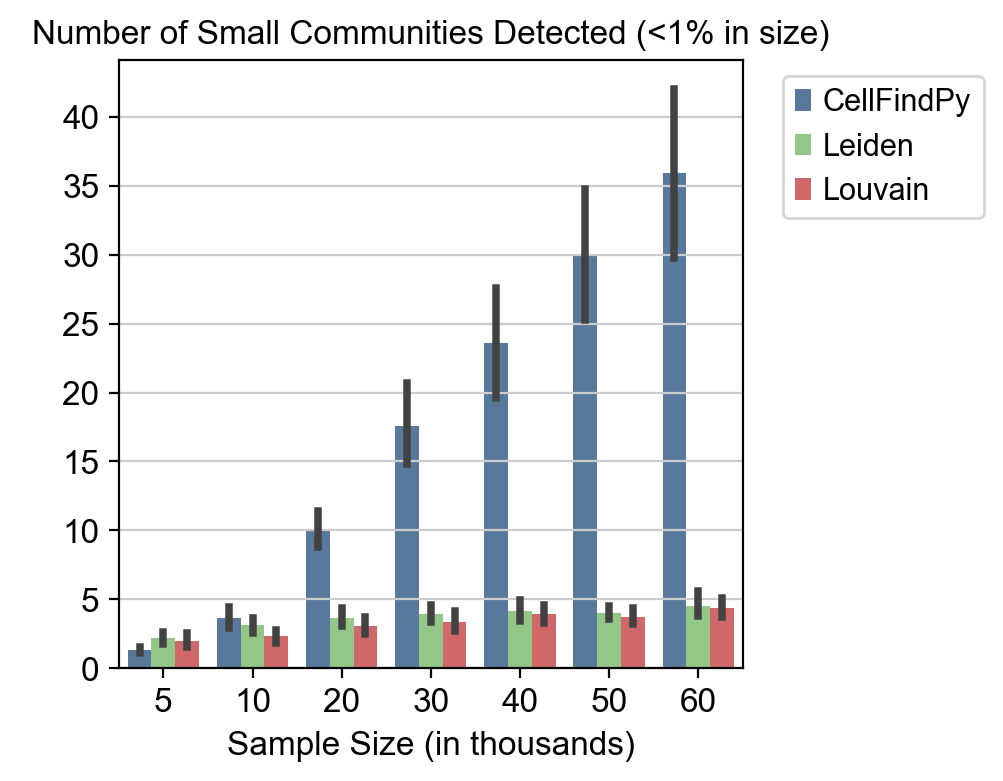

In [7]:
sns.barplot(data=Combined_n, x='Sample_Size', y='Number of Populations', hue='Algorithm',
             palette=[colorrs[0], colorrs[4], colorrs[7], colorrs[9]])
plt.xlabel('Sample Size (in thousands)')
plt.ylabel(' ')
plt.title('Number of Small Communities Detected (<1% in size)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig("Number of Small Communities Detected.png")

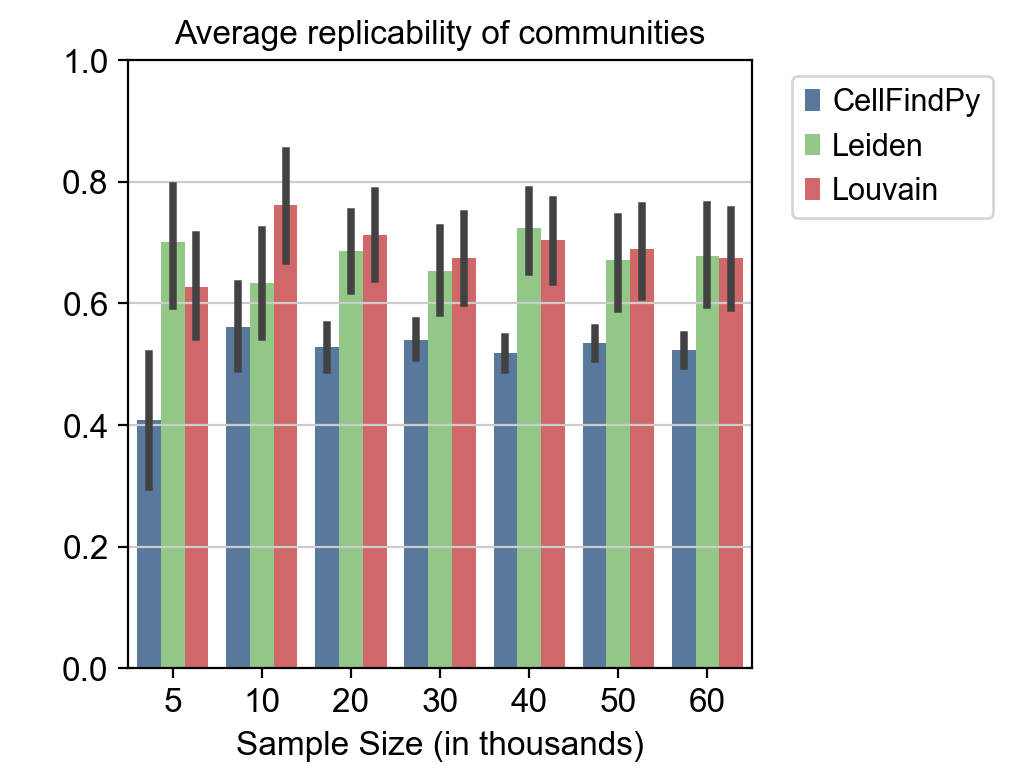

In [5]:
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=12)
colorrs = ["#4E79A7","#A0CBE8","#F28E2B","#FFBE7D","#8CD17D","#B6992D","#499894","#E15759","#FF9D9A","#79706E",
           "#D37295","#FABFD2","#B07AA1","#D4A6C8","#9D7660","#E58606", "#5D69B1", "#24796C",
           '#DAA51B', '#000000', '#99C945', '#ED645A']
sns.barplot(data=Combined, x='Sample_Size', y='Proportion', hue='Algorithm',
              palette=[colorrs[0], colorrs[4], colorrs[7], colorrs[9]])
plt.xlabel('Sample Size (in thousands)')
plt.ylabel(' ')
plt.title('Average replicability of communities')
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig("Average Replicability of communities.png")
